In [ ]:
!pip install control

     |████████████████████████████████| 348kB 7.8MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=74b75122bf6bbac234cbaacffa9fc8448f436e8604951522b331376e10250e95
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [ ]:
!pip install tensorflow==2.2

     |████████████████████████████████| 516.2MB 23kB/s 
     |████████████████████████████████| 3.0MB 43.7MB/s 
     |████████████████████████████████| 460kB 35.9MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [ ]:
import numpy as np
import random
import argparse
from keras.models import model_from_json, Model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
import tensorflow as tensor
tensor.compat.v1.disable_eager_execution()
# from keras.engine.training import collect_trainable_weights
import json
import control
from  control.matlab import *
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import warnings
import random
from keras import initializers


from ReplayBuffer import ReplayBuffer
from DDPG_Actor_Network_fullcycle import ActorNetwork
from DDPG_Critic_Network_fullcycle import CriticNetwork
from OU import OU
import timeit


iterations = []
error_values = []

OU = OU()

tracking_error = []
total_reward = []
class environment():

    def reset(self):
            self.next_error = random.uniform(1.5,5)
            self.kp = random.randrange(0,10)
            self.ki = random.randrange(0,10)
            self.kd = random.randrange(0,10)
            return self.next_error,self.kp, self.ki, self.kd
        

    def env(self ,a) :
            
            
            self.kp = a[0]
            self.ki = a[1]
            self.kd = a[2]

            motor = tf([13.01, 52.91, 57.04, 6.581, 0.2201, 0.001189],[1776, 1.084*(10**4), 2.27*(10**4), 1.764*(10**4), 2820, 167.2, 3.403, 0])
            s = tf([1,0],1)
            PID = self.kp + self.ki/s + self.kd*s
            sys = motor*PID
            feedback_sys = feedback(sys,1,-1)
            
            t = np.arange(0,14000,1)
            y, t = step(feedback_sys, t)
            error = 1-y
            absolute_error = np.absolute(error)
            total_error = np.sum(absolute_error)
            itae  = np.sum(absolute_error*t)
            last_error = self.next_error
            self.next_error = total_error
            reward  = np.exp(-0.5*self.next_error) - np.exp(-0.5*last_error)
            done = False
            if self.next_error < 20:
                done = True
            tracking_error.append(total_error)
            total_reward.append(reward)
            return total_error, reward, done

PID = environment()

def play():
    
    BUFFER_SIZE = 100000
    BATCH_SIZE = 256
    GAMMA = 0.99
    TAU = 0.001     #Target Network HyperParameters
    LRA = 0.0001    #Learning rate for Actor
    LRC = 0.001 
    action_size = 3
    action_dim = 3
    state_dim  = 1
    np.random.seed(1337)
    
    vision = False
    EXPLORE = 100000.
    episode_count = 10000
    max_steps = 1000
    reward = 0
    done = False
    step = 0
    epsilon = 1
    indicator = 0
    train_indicator = 1
    
    config = tensor.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tensor.compat.v1.Session(config=config)
    from keras import backend as K
    tensor.compat.v1.keras.backend.set_session(sess)
    
    actor = ActorNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRA)
    critic = CriticNetwork(sess, state_dim, action_dim, BATCH_SIZE, TAU, LRC)
    buff = ReplayBuffer(BUFFER_SIZE)    #Create replay buffer
    
    for i in range(episode_count):
        print("Episode : " + str(i) + " Replay Buffer " + str(buff.count())) 
        total_reward = 0.
        state,kp,ki,kd = PID.reset()
        print("reset_error", state)

        
        for j in range(max_steps):
            
            loss = 0
            epsilon  -= 1.0/ EXPLORE
            a_t = np.zeros([1, action_size])
            noise_t = np.zeros([1, action_size])
            
            a_t_original = actor.model.predict(np.array([state]))
#             print("kp , ki , kd : ", a_t_original[0])
            noise_t[0][0] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][0],  2 , 0.01, 0.005)
            noise_t[0][1] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][1],  2 , 0.01, 0.005)
            noise_t[0][2] = train_indicator * max(epsilon, 0) * OU.function(a_t_original[0][2], 2 , 0.01, 0.005)
            
            a_t[0][0] = a_t_original[0][0] + noise_t[0][0]
            a_t[0][1] = a_t_original[0][1] + noise_t[0][1]
            a_t[0][2] = a_t_original[0][2] + noise_t[0][2]
            
                    
            print("kp, ki, kd :", a_t[0])
            next_state, reward, done  = PID.env(a_t[0])
            print("error",next_state)
            error_values.append(next_state)
            buff.add(state, a_t[0], reward, next_state, done)   
            batch = buff.getBatch(BATCH_SIZE)
            states = np.asarray([e[0] for e in batch])
            actions = np.asarray([e[1] for e in batch])
            rewards = np.asarray([e[2] for e in batch])
            next_states = np.asarray([e[3] for e in batch])
            dones = np.asarray([e[4] for e in batch])
            y_t = np.asarray([e[1] for e in batch])
            target_q_values = critic.target_model.predict([next_states, actor.target_model.predict(next_states)])
            for k in range(len(batch)):
                if dones[k]:
                    y_t[k] = rewards[k]
                else:
                    y_t[k] = rewards[k] + GAMMA*target_q_values[k]
                    
        
            if (train_indicator):
                loss += critic.model.train_on_batch([(states),actions], y_t) 
#                 print("loss",loss)
                a_for_grad = actor.model.predict(states)
                if buff.count() <= BATCH_SIZE:
                    K= buff.count()
                else:
                    K = BATCH_SIZE
                states = states.reshape(K,1)
                grads = critic.gradients(states, a_for_grad)

                actor.train(states, grads)
                actor.target_train()
                critic.target_train()
                
            
            state = next_state
#             total_reward += reward
#             print("total_reward", reward)
            if j == 999:
                iterations.append(j)
            
            if done:
                iterations.append(j)
                break 
            
                
if __name__ == "__main__":
    play()
warnings.filterwarnings("ignore")

Episode : 0 Replay Buffer 0
reset_error 3.5042893039893466
kp, ki, kd : [0.18591731 0.16791257 0.01839074]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


error 165.7665759390539
kp, ki, kd : [7.17127722 6.14464765 0.00994348]
error 19.119462941329147
Episode : 1 Replay Buffer 2
reset_error 2.3359394291566433
kp, ki, kd : [0.10681234 0.09502499 0.02774335]
error 286.4671672043727
kp, ki, kd : [9.99209105 7.88958431 0.01860194]
error 17.15113285051215
Episode : 2 Replay Buffer 4
reset_error 1.5016941245914373
kp, ki, kd : [0.05834053 0.05472951 0.02849117]
error 492.3015764925514
kp, ki, kd : [12.5266051   8.33342376  0.02291344]
error 15.708564072275799
Episode : 3 Replay Buffer 6
reset_error 3.5223464445892314
kp, ki, kd : [0.09264972 0.04920075 0.01335209]
error 543.5341258101791
kp, ki, kd : [8.93826615 3.6392924  0.01810049]
error 19.009463849491546
Episode : 4 Replay Buffer 8
reset_error 2.3086835243251307
kp, ki, kd : [0.04785226 0.02060148 0.02073784]
error 1283.8297851967789
kp, ki, kd : [11.53096342  0.0182137   0.02003659]
error 278.84107766727095
kp, ki, kd : [1.54517748 0.01521025 0.02664211]
error 1011.6064585153129
kp, ki, 

KeyboardInterrupt: ignored

In [ ]:
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")

NameError: ignored

In [ ]:

len(total_reward)

9022

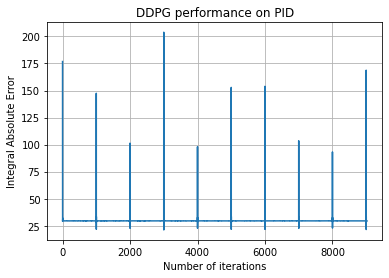

In [ ]:
plt.plot(np.arange(0,9022), error_values[:9022])        
plt.xlabel("Number of iterations")
plt.ylabel("Integral Absolute Error")
plt.title("DDPG performance on PID")
plt.grid()
plt.show()


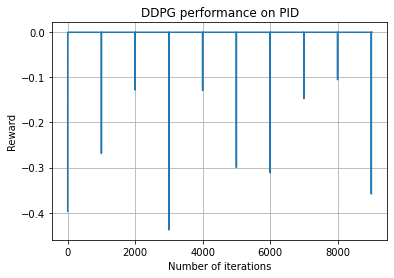

In [ ]:
plt.plot(np.arange(9022), total_reward)
plt.xlabel("Number of iterations")
plt.ylabel("Reward")
plt.title("DDPG performance on PID")
plt.grid()

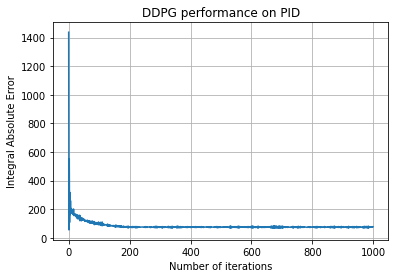

In [ ]:

plt.plot(np.arange(0,1000), error_values[:1000])        
plt.xlabel("Number of iterations")
plt.ylabel("Integral Absolute Error")
plt.title("DDPG performance on PID")
plt.grid()
plt.show()

In [ ]:

len(total_reward)

3654

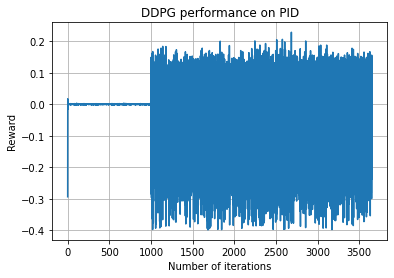

In [ ]:
plt.plot(np.arange(3654), total_reward)
plt.xlabel("Number of iterations")
plt.ylabel("Reward")
plt.title("DDPG performance on PID")
plt.grid()

In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
import control
from  control.matlab import *
import tensorflow as tfl
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
#from Buffer import Buffer
#from OUActionNoise import OUActionNoise

Us = [0]
ts = np.array([0])
yout = []

class environment():

    def __init__(self):

            self.kp = 34.5047797848936
            self.ki = 2.41863698260906
            self.kd = 0.013145
            self.j = 1 
            self.max_input = 100
            #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.I = 0
            

    def reset(self):

            self.Us = [0]
            self.ts = np.array([0])
            self.yout = []
            #self.e00 = 0
           #self.e0 = 0
            self.e1 = 0
            self.e2 = 0
            self.j = 1 
            self.I = 0
            u1 = 0
            
            #self.rl = random.randrange(-self.max_input, self.max_input)
            return np.array([self.e2,u1])

    def step(self ,a) :
            

            mot0 = tf([0.4602, 1.882, 2.038, 0.2338, 0.007103], [62.85, 383.5, 803.4, 624.1, 99.79, 5.916, 0.1204])
            self.rl = np.clip(a, 0, self.max_input)[0]
            
            P = 34.5047797848936*self.e2
            self.I = self.I + 2.41863698260906*(self.e2)*0.1
            D = -0.013145*(self.e2-self.e1)/0.1
            self.u = P + self.I + D
            
            uu = self.u + self.rl
            
            self.Us = np.append(self.Us,uu)
            self.ts = np.append(self.ts,0.1*self.j)
            y, T, xoutd = lsim(3.6*mot0, U=self.Us, T=self.ts)
            self.yout.append(y[-1])
            #self.ynow = y[-1]
            self.e1 = self.e2
            self.e2 = 30-y[-1]
            self.j+=1
            P1 = 34.5047797848936*self.e2
            I1 = self.I
            I1 = I1 + 2.41863698260906*(self.e2)*0.1
            D1 = -0.013145*(self.e2-self.e1)/0.1
            u1 = P1 + I1 + D1
            
            
            #reward = 0.8*np.exp(-0.5*(self.e2)**2) + 0.2*np.exp(-np.absolute(self.rl))
            reward = -np.absolute(self.e2)

            if self.j >= 500:
              done = True
            else :
              done = False
            self.state = np.array([self.e2,u1])
            return self.state, reward, done, {}

env = environment()
num_states = 2
num_actions = 1
upper_bound = 100
lower_bound = 0

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tfl.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tfl.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tfl.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tfl.math.reduce_mean(tfl.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tfl.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tfl.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tfl.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tfl.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tfl.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tfl.cast(reward_batch, dtype=tfl.float32)
        next_state_batch = tfl.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tfl.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tfl.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tfl.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tfl.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tfl.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tfl.keras.optimizers.Adam(critic_lr)
actor_optimizer = tfl.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(100000, 128)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tfl.expand_dims(tfl.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        #print(j)
        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    print("Episode * {} * Episodic Reward is ==> {}".format(ep, episodic_reward))
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

/usr/local/lib/python3.7/dist-packages/control/timeresp.py:294: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  "return_x specified for a transfer function system. Internal "


Episode * 0 * Episodic Reward is ==> -664.991309297555
Episode * 1 * Episodic Reward is ==> -668.1614842805686
Episode * 2 * Episodic Reward is ==> -668.1614842805686
Episode * 3 * Episodic Reward is ==> -668.1614842805686
Episode * 4 * Episodic Reward is ==> -668.1614842805686


KeyboardInterrupt: ignored